# Data Cleaning and Preperation Methods

In [1]:
import scipy.stats as stats
import pylab
import numpy as np
import pandas as pd
import statsmodels.api as sm
import mplfinance as fplt
import math
from matplotlib import pyplot as plt
import scipy

We have spoken about a number of data sets so far. Data falls into one of four catigories. The methods you apply towards data are broadly similar, but certain sets do have their own techniques. Here are some example of the types of data we see in finance and how we categorize them.

|Fundamental Data|Market Data               |Analytics             |Alternative Data|
|----------------|--------------------------|----------------------|----------------|
|market cap      |price/yield/implied vol   |credit rating         |Twitter post    |
|PE ratio        |volume                    |analyst recommendation|credit card data|
|EBITDA          |dividends/coupons/delivery|earning report        |Satellite data  |
|sales           |quotes                    |news                  |searches        |

## Splits and Dividends

### Splits

A stock split is a kind of corporate action (https://en.wikipedia.org/wiki/Corporate_action). Companies can issue stock splits for a variety of reasons. The most common is that the price of the stock has become so high that it deters some buyers. This can reduce the trading volume of the stock.  A stock split changes the number of share in the market. The market capitalization of the stock must remain the same. Since
$$number\; of \; share \times share \; price = market\;capitalization$$
changing the number of shares will also cause the share price to change. Some data is adjusted for splits, some is not. Here is an example below along with some some corporate actions data. Consider the following daily prices on Apple.

In [2]:
AAPLwithSplits = pd.read_csv('/Users/michael/Documents/Stony Brook/AMS 691 Fall 2020/Lecture004/AAPLwithSplits.csv')

In [3]:
AAPLwithSplits.head()

,Date,Ticker,Open,High,Low,Close,Volume
0,12/12/80,AAPL,28.750,28.875,28.750,28.750,167512
1,12/15/80,AAPL,27.250,27.375,27.250,27.250,62816
2,12/16/80,AAPL,25.250,25.375,25.250,25.250,37760
3,12/17/80,AAPL,25.875,26.000,25.875,25.875,30872
4,12/18/80,AAPL,26.625,26.750,26.625,26.625,26232


We can search for the presence of splits in many ways. The quick and dirty one is to use a graph.

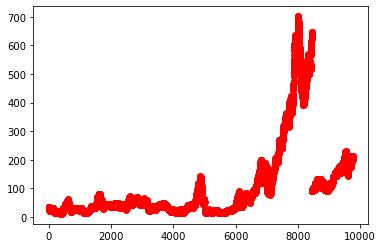

In [4]:
plt.plot(np.array(AAPLwithSplits['Close']),'ro')

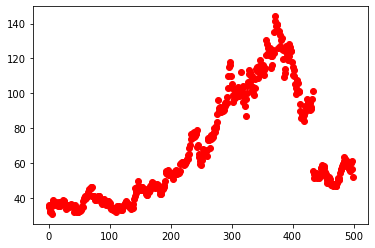

In [6]:
plt.plot(np.array(AAPLwithSplits['Close'][4500:5000]),'ro')

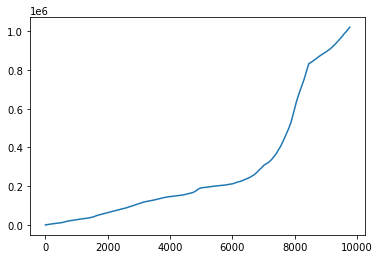

In [5]:
plt.plot(np.cumsum(np.array(AAPLwithSplits['Close'])))

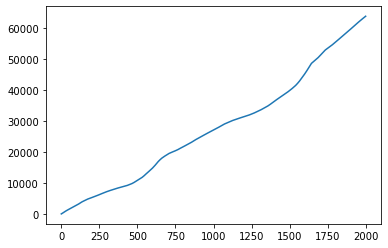

In [11]:
plt.plot(np.cumsum(np.array(AAPLwithSplits['Close'][:2000])))

The best thing to do is use corporate action data. This will give use the split dates and the ratio. Maybe...

In [7]:
Actions_data = pd.read_csv('/Users/michael/Documents/Stony Brook/AMS 691 Fall 2020/Lecture004/ACTIONS_DATA.csv')

In [8]:
Actions_data.head()

,date,action,ticker,name,value,contraticker,contraname
0,2019-08-26,split,TRNX,Taronis Technologies Inc,0.200,NaN,NaN
1,2019-08-23,split,SPSC,Sps Commerce Inc,2.000,NaN,NaN
2,2019-08-22,split,TOPS,Top Ships Inc,0.050,NaN,NaN
3,2019-08-21,split,GLAE,Glassbridge Enterprises Inc,0.005,NaN,NaN
4,2019-08-20,split,IPWR,Ideal Power Inc,0.100,NaN,NaN


In [9]:
Actions_data[Actions_data['ticker'] == 'AAPL']

,date,action,ticker,name,value,contraticker,contraname
1572,2014-06-09,split,AAPL,Apple Inc,7.0,NaN,NaN
4457,2005-02-28,split,AAPL,Apple Inc,2.0,NaN,NaN
6646,2000-06-21,split,AAPL,Apple Inc,2.0,NaN,NaN


We should look at lots of graphs over different time frames to be sure.

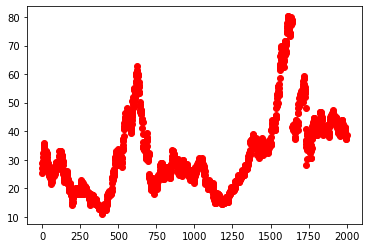

In [10]:
plt.plot(np.array(AAPLwithSplits['Close'][:2000]),'ro')

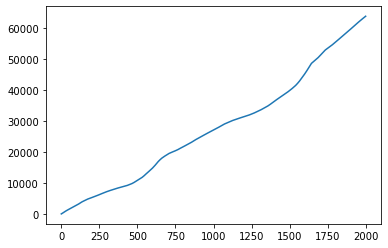

In [12]:
plt.plot(np.cumsum(np.array(AAPLwithSplits['Close'][:2000])))

In [13]:
AAPLwithSplits[1640:1650]

,Date,Ticker,Open,High,Low,Close,Volume
1640,6/10/87,AAPL,78.50,80.250,78.000,78.50,52224
1641,6/11/87,AAPL,79.00,80.000,78.000,79.00,44776
1642,6/12/87,AAPL,79.00,79.750,78.750,79.00,36344
1643,6/15/87,AAPL,78.50,79.500,77.500,78.50,46724
1644,6/16/87,AAPL,41.50,41.750,38.000,41.50,122708
1645,6/17/87,AAPL,40.50,42.500,40.000,40.50,106788
1646,6/18/87,AAPL,41.50,41.750,39.500,41.50,82216
1647,6/19/87,AAPL,41.00,41.750,40.375,41.00,44896
1648,6/22/87,AAPL,42.00,42.250,40.875,42.00,60644
1649,6/23/87,AAPL,41.25,42.125,40.750,41.25,28876


There was a split on June 16th 1987, the corporate actions data above was incomplete! A company can split a stock $N$ to 1. When $N$ is greater than 1 it is called split, when $N$ is less than 1 it is called a reverse split. We will denote a split at time $T$ as $N_T$. In order to adjust for a split at time $T$ we must multiply all the prices before time $T$. We adjust as follows.
$$split\; adjusted\;price(t) = \frac{1}{N_T}Price(t) \;\;\; t\in\{1, \ldots, T-1\}$$

### Dividends

A dividend is a way a company can share it's profits with it's shareholders. Not all public companies issue a dividend, but some do. This is typically a cash payout to the share holders at a fixed amount per share. Dividends should be incorperated into the price of a stock when modeling it. The dividend-adjusted return is a calculation of a stock's return that relies not only on capital appreciation but also the dividends that shareholders receive. This adjustment provides investors with a more accurate evaluation of the return of an income-producing security over a specified holding period. There are a number of approaches we can take to adjust a stock price for a dividend. We choose the following approach because it will not impact the daily returns. Suppose that a company issues a dividend of $d$ dollars per share at time $T$. Then
$$Dividend\;Adjusted\;Price = \frac{Price(T-1)-d}{Price(T-1)} \times Price(t)    t \in \{1,\ldots,T-1\}$$

IBM is a classic example of a company that issues dividends. the problem is there are a lot of them. Fortunately we have access to a list of IBM corporate actions. We can use this to create a time series which will help us adjust for dividends. Below is a download from Global Financial Data. This not only has non-adjusted daily OHLCV data, but dates and amounts of all splits and dividends.

In [14]:
IBMwithSplits = pd.read_csv('/Users/michael/Documents/Stony Brook/AMS 691 Fall 2020/Lecture004/IBMactionsandOCHLV.csv')
IBMwithSplits.head()

,Date,Ticker,Open,High,Low,Close,Volume
0,8/31/11,IBM,55.0,60.0,50.0,55.0,0.0
1,9/30/11,IBM,55.0,60.0,50.0,55.0,0.0
2,10/31/11,IBM,54.0,56.0,52.0,54.0,0.0
3,11/29/11,IBM,53.5,54.5,52.5,53.5,0.0
4,12/30/11,IBM,49.5,51.0,48.0,49.5,0.0


In [15]:
IBMactions = pd.read_excel('/Users/michael/Documents/Stony Brook/AMS 691 Fall 2020/Lecture004/IBMactions.xlsx')
IBMactions.head()

,Ticker,Action,Amount,Declaration Date,Ex-Dividend Date,Record Date,Payment Date,Notes,Currency
0,IBM,Cash Dividend,1,NaT,1913-03-31,NaT,1913-04-10,NaN,USD
1,IBM,Cash Dividend,1,NaT,1913-06-30,NaT,1913-07-10,NaN,USD
2,IBM,Cash Dividend,1,NaT,1913-09-30,NaT,1913-10-10,NaN,USD
3,IBM,Cash Dividend,1,NaT,1916-03-25,NaT,1916-04-10,Declared 4% paayble in quarterly installments.,USD
4,IBM,Cash Dividend,1,NaT,1916-06-24,NaT,1916-07-10,NaN,USD


In [16]:
IBMcashdividends = IBMactions[IBMactions["Action"] == "Cash Dividend"]
IBMcashdividends.head()

,Ticker,Action,Amount,Declaration Date,Ex-Dividend Date,Record Date,Payment Date,Notes,Currency
0,IBM,Cash Dividend,1,NaT,1913-03-31,NaT,1913-04-10,NaN,USD
1,IBM,Cash Dividend,1,NaT,1913-06-30,NaT,1913-07-10,NaN,USD
2,IBM,Cash Dividend,1,NaT,1913-09-30,NaT,1913-10-10,NaN,USD
3,IBM,Cash Dividend,1,NaT,1916-03-25,NaT,1916-04-10,Declared 4% paayble in quarterly installments.,USD
4,IBM,Cash Dividend,1,NaT,1916-06-24,NaT,1916-07-10,NaN,USD


## Survivor Bias

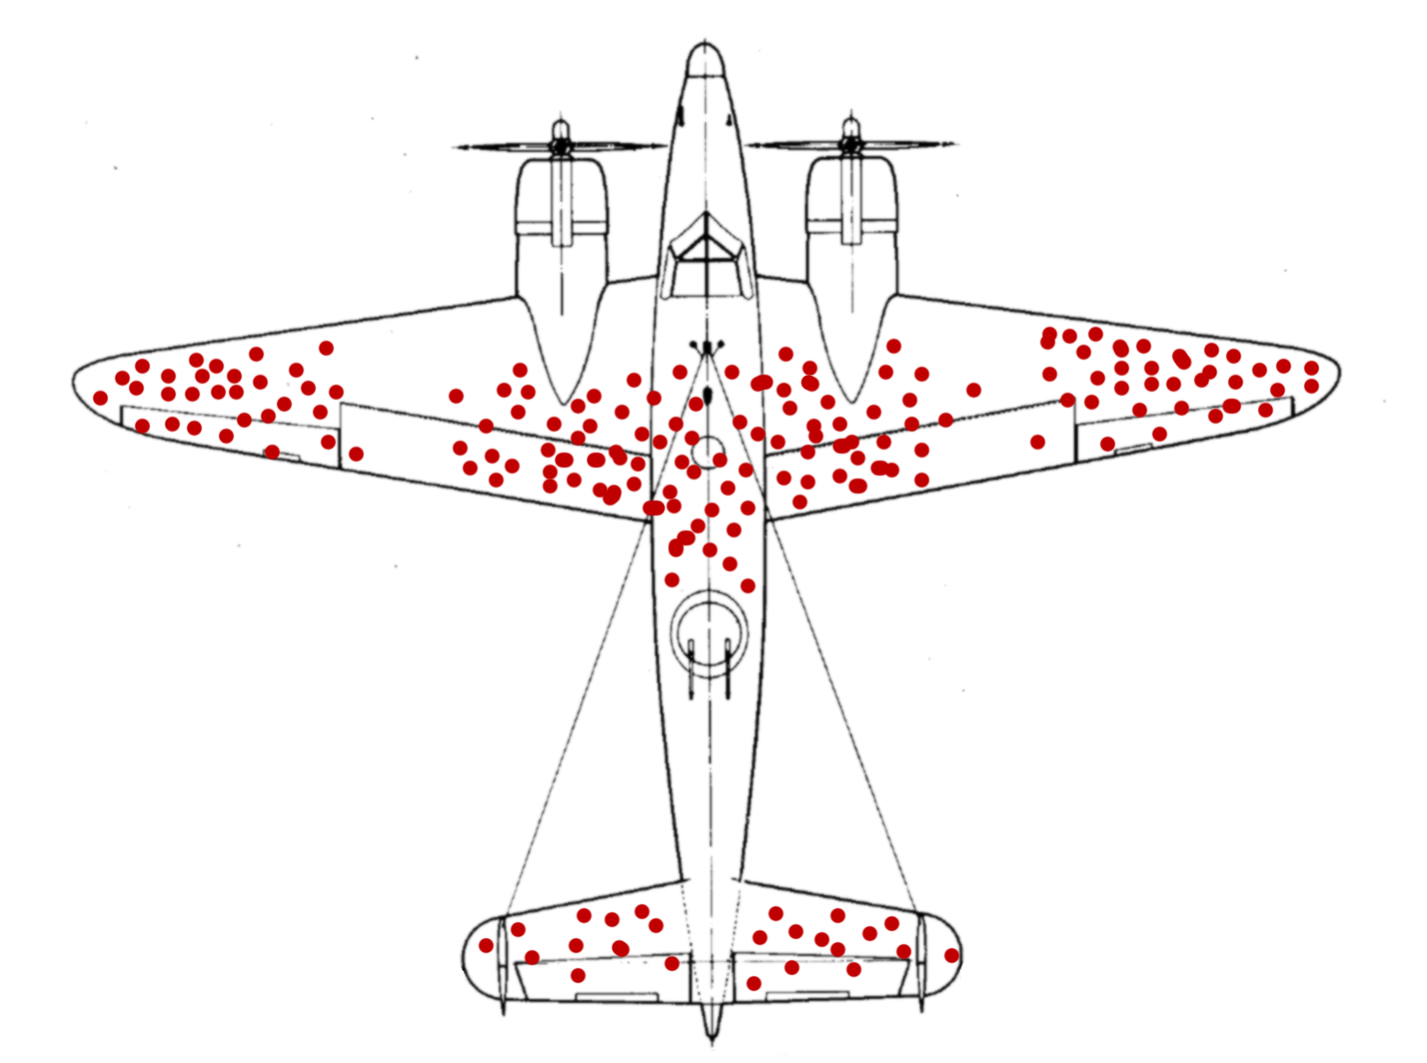

In [17]:
from IPython.display import Image
Image(filename="/Users/michael/Documents/Stony Brook/AMS 691 Fall 2020/Lecture004/Survivorship-bias.png",
     width=800, height=600)

The illustration above tracks the most frequent bullet holes on allied planes that took anti-aircraft fire from the Nazis during World War 2.

The concentration of damage were most evident in three areas of the plane: the fuselage, the outer wings, and the tail. Initially the military wanted to reinforce these areas because obviously these were the most vulnerable areas.

However, Jewish mathematician Abraham Wald, who fled Nazi-occupied Austria, found a critical flaw with the analysis. The military had only observed planes that made it safely back to base. This meant that the bullet holes shown in the illustration above were not very dangerous to the integrity of the plane. Armor was needed on the areas that had few bullet holes such as the cockpit or the engines. The military never saw planes with bullet holes in those areas because those planes never made it back.

This phenomenon is called survivorship bias and refers to a logical error of focusing on the things that made it past some sort of selection process while overlooking those that did not.

Survivorship or survivor bias is one of the more serious problems which impacts financial data sets. A data set that has survivor bias will often lead to the development of strategies and model parameters which are wildly different in a back test as compared to live trading. To make matters worse most data sets you can buy have survivor bias, it's much more common than most people realize. Having said this, you have probably just conjectured, data sets which are survivor bias free are rare and expensive.  

There are many things that contribute to survivorship bias. Most historical stock databases do not include stocks which have disappeared due to bankruptcies, delistings, mergers, or acquisitions. The database only contains stocks which have survived these kinds of events. This goes well beyond stock data, it can also be applied to futures, options, bonds, currencies, indices, mutual funds, and hedge funds. It even goes beyond financial data as seen above. 

A common "rookie" mistake is to develop a strategy based on an investment universe like the S&P 500. People will commonly use the current constituents of the S&P 500 in backtests of their strategy. The mistake is that the composition of the S&P 500 changes overtime. Stocks which are added to the S&P typically get a price boost at the time of inclusion and those which are remove suffer from price deflation. Stocks like IBM which have been in the S&P for a very long time are the survivors. 

Here is a list of the companies that have been removed (along with their replacements) from the S&P 500 over the last 60 years.

In [18]:
SPmembers = pd.read_csv("/Users/michael/Documents/Stony Brook/AMS 691 Fall 2020/Lecture004/SP500.csv")
SPmembers[-5:-1]

,date,action,ticker,name,contraticker,contraname,note
47369,1957-03-04,added,VO1,Seagram Co Ltd,NaN,NaN,NaN
47370,1957-03-04,added,WGL,Wgl Holdings Inc,NaN,NaN,NaN
47371,1957-03-04,added,WLA,Warner Lambert Co,NaN,NaN,NaN
47372,1957-03-04,added,WNDXQ,Winn Dixie Stores Inc,NaN,NaN,NaN


In [19]:
SPmembers.head()

,date,action,ticker,name,contraticker,contraname,note
0,2020-08-28,current,A,Agilent Technologies Inc,NaN,NaN,NaN
1,2020-08-28,current,AAL,American Airlines Group Inc,NaN,NaN,NaN
2,2020-08-28,current,AAP,Advance Auto Parts Inc,NaN,NaN,NaN
3,2020-08-28,current,AAPL,Apple Inc,NaN,NaN,NaN
4,2020-08-28,current,ABBV,AbbVie Inc,NaN,NaN,NaN


In [20]:
len(SPmembers)

47374

In [24]:
SPmembers[30250:30300]

,date,action,ticker,name,contraticker,contraname,note
30250,2006-03-31,historical,TE,Teco Energy Inc,NaN,NaN,NaN
30251,2006-03-31,historical,TEK,Tektronix Inc,NaN,NaN,NaN
30252,2006-03-31,historical,TER,Teradyne Inc,NaN,NaN,NaN
30253,2006-03-31,historical,TFC,Truist Financial Corp,NaN,NaN,NaN
30254,2006-03-31,historical,TFCF,Twenty-First Century Fox Inc,NaN,NaN,NaN
30255,2006-03-31,historical,TGNA,Tegna Inc,NaN,NaN,NaN
30256,2006-03-31,historical,TGT,Target Corp,NaN,NaN,NaN
30257,2006-03-31,historical,THC,Tenet Healthcare Corp,NaN,NaN,NaN
30258,2006-03-31,historical,TIF,Tiffany & Co,NaN,NaN,NaN
30259,2006-03-31,historical,TIN,Temple Inland Inc,NaN,NaN,NaN


Sometimes a researcher will use the constituents of an index as the investment universe which they select stocks from for a simple buy low-priced stocks strategy or perhaps a momentum play.  Suppose from our universe we pick the 10 stocks that have the lowest closing prices at the beginning of the year and hold them for one year. Let's start in 2001. If we pick our stocks from a database that has survivor bias here is what we would get.

|Symbol|Closing Price on 1/2/2001|Closing Price on 1/2/2002|
|------|-------------------------|-------------------------|
|MDM|0.3125|0.49|
|ENGA|0.8438|0.44|
|NEOF|0.875|27.9|
|ENP|0.875|0.05|
|MVL|0.9583|2.5|
|URBN|1.0156|3.0688|
|FNV|1.0625|0.81|
|APT|1.125|0.88|
|FLIR|1.2813|9.475|
|RAZF|1.3438|0.25|

Assuming we equally weighted our capital across each of these stocks this portfolio gives a return of 388%! In fact applying this strategy across different time periods will yield similar results. Of course the problem is that we used a database with survivor bias. Had we used a database which was survivor bias free here is what we would have found.

|Symbol|Closing Price on 1/2/2001|Closing Price on 1/2/2002|Terminal Price|
|------|-------------------------|-------------------------|--------------|
|ETYS|0.2188|NaN|0.125|
|MDM|0.3125|0.49|0.49|
|INTW|0.4063|NaN|0.11|
|FDHG|0.5|NaN|0.33|
|OGNC|0.6875|NaN|0.2|
|MPLX|0.7188|NaN|0.8|
|GTS|0.75|NaN|0.35|
|BUYX|0.75|NaN|0.17|
|PSIX|0.75|NaN|0.2188|

With the exception of MDM all of these companies went out of business during the dot com bubble. Assuming we were able to get out at the terminal price this portfolio returns - 42%. If we can't get out at the terminal price this portfolio is almost a total loss. Survivorship bias tends to make things look to good to be true.

## Bad Data

Active investors and brokers use the I/B/E/S (Institutional Brokers’ Estimate System) database to gather public company financial data assembled by stock analysts. This is the primary venue for gathering earnings estimates. It is owned and operated by Thomas Reuters, one of the biggest data providers in finance. There are estimates for most of the fundamental data discussed in earlier lectures: enterprise value, net income, EBITDA, PE ratio, etc.

Based on their research, analysts also give each stock a buy, sell, or hold recommendation.  These estimates and recommendations have great influence on trade action, trading strategy development, and are the subject of a great amount of research. Unfortunately, as you might expect, this data has a number of issue. Most of them are temporal in nature. 

An important paper which illustrates some of these issues is Rewriting History by Ljungqvist, Malloy, and Marston (2008). What the authors found was, by comparing sequences of downloads over a 7 year period, as much as 21% of observations were changed in a non-random way. Some of the things they uncovered are changes in analyst recommendation levels, addition and deletion of reports, and removal of analyst names. 

- Tens of thousands of historical recommendations have been added, dropped, altered, or anonymized (deletion of the analyst’s name, but not the recommendation). The data handling errors that lead to this have existed and continue to exist throughout the existence of the database. 
- The contents of the database have become date dependent as a result of the changes.
- Both academics and practitioners use IBES data for trading signals, upgrades and downgrades are a prominent example. As much as 34% of trading signals are reclassified as compared to their original value.


## Removing Data

In [25]:
raw_data = pd.read_csv("/Users/michael/Data/TRADE_20181105.csv")

price_vol_data = raw_data[
    ["b'Time", "Symbol", "Trade Volume", "Trade Price", "Sale Condition", "Trade Correction Indicator"]
   ]

price_vol_data[:5]

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
0,b'090004996509000,A,50,65.5000,FTI,0
1,b'091705411537000,A,12,65.9300,TI,0
2,b'093000012344000,A,16450,66.0300,O,0
3,b'093031335250000,A,48,66.0424,I,0
4,b'093035234224000,A,100,66.1300,,0


In [26]:
AAPL_Price_vol = price_vol_data.loc[price_vol_data['Symbol'] == 'AAPL']
AAPL_Price_vol[:5]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
143462,b'040000014803305,AAPL,182,206.5,@ T,0
143463,b'040000014803699,AAPL,144,206.5,@ T,0
143464,b'040000014804021,AAPL,30,206.5,@ TI,0
143465,b'040000014804217,AAPL,1,206.5,@ TI,0
143466,b'040000014861857,AAPL,1,206.5,@ TI,0


In [ ]:
AAPL_Price_vol[-5:-1]

Notice the index of the date frame. We shoudl reset it.

In [27]:
AAPL_Price_vol = AAPL_Price_vol.reset_index()
del AAPL_Price_vol['index']
AAPL_Price_vol[:5]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
0,b'040000014803305,AAPL,182,206.5,@ T,0
1,b'040000014803699,AAPL,144,206.5,@ T,0
2,b'040000014804021,AAPL,30,206.5,@ TI,0
3,b'040000014804217,AAPL,1,206.5,@ TI,0
4,b'040000014861857,AAPL,1,206.5,@ TI,0


Notice that at the beginning and end of the data frame we see a lot of trade which took place outside of normal trading hours (9:30 - 4:00). You may find this data valuable, you may not. For us we are going to stick to data within trading hours so we will remove trades which take place before the open or after the close. The label used for these trades depends on wether the trade came from CTA or UTP. It is either a T or a U.

In [28]:
AAPL_Price_vol = AAPL_Price_vol[~AAPL_Price_vol['Sale Condition'].str.contains('T')]

In [29]:
AAPL_Price_vol = AAPL_Price_vol[~AAPL_Price_vol['Sale Condition'].str.contains('U')]

In [30]:
AAPL_Price_vol[:5]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
9757,b'093000036753311,AAPL,20,204.39,@ I,0
9759,b'093000079162915,AAPL,25,204.39,@ I,0
9760,b'093000079456147,AAPL,55,204.39,@ I,0
9761,b'093000085361166,AAPL,5,204.35,@ I,0
9762,b'093000087596718,AAPL,2,204.35,@ I,0


Notice we need to reindex again.

In [31]:
AAPL_Price_vol = AAPL_Price_vol.reset_index()
del AAPL_Price_vol['index']
AAPL_Price_vol[:5]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
0,b'093000036753311,AAPL,20,204.39,@ I,0
1,b'093000079162915,AAPL,25,204.39,@ I,0
2,b'093000079456147,AAPL,55,204.39,@ I,0
3,b'093000085361166,AAPL,5,204.35,@ I,0
4,b'093000087596718,AAPL,2,204.35,@ I,0


At the open of the market you have the market center opening price and the opening print. Both of these are typically large volume trades. This can be misleading. Most exchanges run an auction before open and close. Usually a large number of trades are sitting in the book as a result. They accululate because during the auction they are unpaired. When the auction concludes a large trade is printed reflecting the clearing price. This is most likely not a single trade. It will create an outlier in terms of volume. 

In [32]:
AAPL_Price_vol[AAPL_Price_vol['Sale Condition'].str.contains('O')]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
194,b'093000757255129,AAPL,727001,204.39,@O X,0


In [35]:
AAPL_Price_vol[193:197]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
193,b'093000755135779,AAPL,100,204.29,@F,0
194,b'093000757255129,AAPL,727001,204.39,@O X,0
195,b'093000757373258,AAPL,727001,204.39,@ Q,0
196,b'093000757487223,AAPL,1,204.38,@ I,0


In [36]:
AAPL_Price_vol = AAPL_Price_vol[~AAPL_Price_vol['Sale Condition'].str.contains('O')]

In [33]:
AAPL_Price_vol[AAPL_Price_vol['Sale Condition'].str.contains('Q')]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
6,b'093000089386294,AAPL,7,204.35,@ Q,0
195,b'093000757373258,AAPL,727001,204.39,@ Q,0


In [37]:
AAPL_Price_vol[AAPL_Price_vol['Sale Condition'].str.contains('6')]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
556774,b'160000771774087,AAPL,1956676,201.59,@6 X,0


In [38]:
AAPL_Price_vol = AAPL_Price_vol[~AAPL_Price_vol['Sale Condition'].str.contains('6')]

In [39]:
AAPL_Price_vol[AAPL_Price_vol['Sale Condition'].str.contains('M')]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
556771,b'160000225387894,AAPL,2374,201.57,@ M,0
556775,b'160000771788010,AAPL,1956676,201.59,@ M,0


Some of this data should be removed, some is legit. Consider the two trades above. The first is the actual last trade of the day, the second is a result of the closing auction. 

In [40]:
AAPL_Price_vol = AAPL_Price_vol.drop([556775,195])

In [41]:
AAPL_Price_vol[AAPL_Price_vol['Sale Condition'].str.contains('M')]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
556771,b'160000225387894,AAPL,2374,201.57,@ M,0


In [42]:
AAPL_Price_vol[AAPL_Price_vol['Sale Condition'].str.contains('Q')]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
6,b'093000089386294,AAPL,7,204.35,@ Q,0


Sometimes trades are reported late by exchanges. These are called out of sequence trades. The price which is reported for these trades can be very far from the prevailing market prices at the time. The should be removed from the data.  

In [43]:
AAPL_Price_vol[AAPL_Price_vol['Sale Condition'].str.contains('Z')]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
7162,b'093014522825612,AAPL,1,203.6000,@ ZI,0
9697,b'093036626815438,AAPL,73,203.3274,@ ZI,0
98928,b'095405451561926,AAPL,50,201.7494,@ ZI,0
110070,b'095706482129601,AAPL,489,200.9200,@ Z,0
181285,b'101400527764376,AAPL,100,198.9400,@ Z,0
181288,b'101400544146695,AAPL,70,198.9400,@ ZI,0
402588,b'123658736376039,AAPL,27,199.7200,@ ZI,0
402860,b'123727117089639,AAPL,15,203.9660,@ ZI,0
434594,b'132852004214342,AAPL,33,205.8980,@ ZI,0


In [44]:
AAPL_Price_vol = AAPL_Price_vol[~AAPL_Price_vol['Sale Condition'].str.contains('Z')]

Sometime trades are report by exchanges which contain errors. Errors of various types can occur. For example a trade may end up being cancelled so that in reality it never took place. Other times some aspect of the record of the trade was reported in error. In all of these situations the current record refelects data which was corrected after the actual trading day. Including this kind of data in your data set will introduce a look ahead bias. You can be overly cautious and just remove them all, but you shoudl consider the types of errors before doing this.

In [46]:
AAPL_Price_vol[AAPL_Price_vol['Trade Correction Indicator'] != 0]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
10481,b'093045696168640,AAPL,60,203.7178,@ I,8
10483,b'093045703181447,AAPL,91,203.7137,@ I,8
10485,b'093045838189808,AAPL,1,203.7137,@4 I,8
86387,b'094918996260122,AAPL,100,201.7494,@,8
94950,b'095228260286490,AAPL,60,203.7178,@ I,10
94951,b'095228260472134,AAPL,91,203.7137,@ I,10
98927,b'095405451341162,AAPL,100,201.7494,@,10
108087,b'095703584856933,AAPL,2,201.0000,@ I,8
108092,b'095703585098316,AAPL,20,201.0000,@ I,8
108093,b'095703585226695,AAPL,47,201.0000,@ I,8


In [47]:
AAPL_Price_vol = AAPL_Price_vol[AAPL_Price_vol['Trade Correction Indicator'] == 0]

Next we correct the time index and convert it into a time stamp object.

In [48]:
AAPL_Price_vol[:5]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
0,b'093000036753311,AAPL,20,204.39,@ I,0
1,b'093000079162915,AAPL,25,204.39,@ I,0
2,b'093000079456147,AAPL,55,204.39,@ I,0
3,b'093000085361166,AAPL,5,204.35,@ I,0
4,b'093000087596718,AAPL,2,204.35,@ I,0


In [49]:
AAPL_Price_vol["b'Time"] = AAPL_Price_vol["b'Time"].str.lstrip("'b'")

In [50]:
AAPL_Price_vol

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
0,093000036753311,AAPL,20,204.39,@ I,0
1,093000079162915,AAPL,25,204.39,@ I,0
2,093000079456147,AAPL,55,204.39,@ I,0
3,093000085361166,AAPL,5,204.35,@ I,0
4,093000087596718,AAPL,2,204.35,@ I,0
...,...,...,...,...,...,...
556771,160000225387894,AAPL,2374,201.57,@ M,0
556772,160000246734134,AAPL,80,201.57,@F I,0
556773,160000248124769,AAPL,120,201.57,@F,0
556776,160001735360409,AAPL,1973,201.59,@,0


In [51]:
AAPL_Price_vol["b'Time"] = pd.to_datetime(AAPL_Price_vol["b'Time"], format='%H%M%S%f')

In [52]:
AAPL_Price_vol[:5]

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
0,1900-01-01 09:30:00.036753311,AAPL,20,204.39,@ I,0
1,1900-01-01 09:30:00.079162915,AAPL,25,204.39,@ I,0
2,1900-01-01 09:30:00.079456147,AAPL,55,204.39,@ I,0
3,1900-01-01 09:30:00.085361166,AAPL,5,204.35,@ I,0
4,1900-01-01 09:30:00.087596718,AAPL,2,204.35,@ I,0


Drop the date.

Reindex

In [53]:
AAPL_Price_vol = AAPL_Price_vol.reset_index()
del AAPL_Price_vol['index']

In [54]:
AAPL_Price_vol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556717 entries, 0 to 556716
Data columns (total 6 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   b'Time                      556717 non-null  datetime64[ns]
 1   Symbol                      556717 non-null  object        
 2   Trade Volume                556717 non-null  int64         
 3   Trade Price                 556717 non-null  float64       
 4   Sale Condition              556717 non-null  object        
 5   Trade Correction Indicator  556717 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 25.5+ MB


In [55]:
AAPL_Price_vol

,b'Time,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
0,1900-01-01 09:30:00.036753311,AAPL,20,204.39,@ I,0
1,1900-01-01 09:30:00.079162915,AAPL,25,204.39,@ I,0
2,1900-01-01 09:30:00.079456147,AAPL,55,204.39,@ I,0
3,1900-01-01 09:30:00.085361166,AAPL,5,204.35,@ I,0
4,1900-01-01 09:30:00.087596718,AAPL,2,204.35,@ I,0
...,...,...,...,...,...,...
556712,1900-01-01 16:00:00.225387894,AAPL,2374,201.57,@ M,0
556713,1900-01-01 16:00:00.246734134,AAPL,80,201.57,@F I,0
556714,1900-01-01 16:00:00.248124769,AAPL,120,201.57,@F,0
556715,1900-01-01 16:00:01.735360409,AAPL,1973,201.59,@,0


## Bars

In the last lecture we introduced candlestick charts. These are also commonly referred to as candles or bars. These charts display open, high, low, close, and volume data all at the same time. The independent variable used in is usually time. While in certain contexts indexing by time is the correct approach, in others it is not. Generating bars is all about they way you choose to sample data and they way you sample data depends on your goals. For example if we sample by time you will find that volume chages wildly throughout the day, witht he highest volumes being during open and close. If your goal is to model a volume process you probably want to sample by volume, not time as we will see below.

### Time Bars

Time bars sample based on a predetermined interval of time. So for example we can talk about 5 minute bars or 10 minutes bars, even 2 week bars. Whatever time interval you like can be applied here with in reason. With in that time period we look at open, high, low, close, and volume. Sometimes we will look at other things as well like VWAP and TWAP (volume weighted adjusted prices and time weighted adjusted prices),more on this later. For now we will stick to OHLCV data. Although time bars are useful in certian contexts, they do have drawbacks

- Time bars do not always agree with the rate of information arrival in the market. They tend to over sample during low activity periods and under sample during high activity periods.

- The time series which are generated by time bar sampling tend to have poor statitical properties. For example no variance.

Recall the the Pandas package was developed by a quant. It should then be no surprise that there is some level of functionality for doing this kind of sampling. To use it the dataframe must have an index of date time objects named Date_Time. We will modify our existing dataframe to create one.

In [56]:
AAPL_timeindex = AAPL_Price_vol.set_index("b'Time")

In [57]:
AAPL_timeindex.index.names = ["Date_Time"]

In [58]:
AAPL_timeindex

,Symbol,Trade Volume,Trade Price,Sale Condition,Trade Correction Indicator
Date_Time,,,,,
1900-01-01 09:30:00.036753311,AAPL,20,204.39,@ I,0
1900-01-01 09:30:00.079162915,AAPL,25,204.39,@ I,0
1900-01-01 09:30:00.079456147,AAPL,55,204.39,@ I,0
1900-01-01 09:30:00.085361166,AAPL,5,204.35,@ I,0
1900-01-01 09:30:00.087596718,AAPL,2,204.35,@ I,0
...,...,...,...,...,...
1900-01-01 16:00:00.225387894,AAPL,2374,201.57,@ M,0
1900-01-01 16:00:00.246734134,AAPL,80,201.57,@F I,0
1900-01-01 16:00:00.248124769,AAPL,120,201.57,@F,0


We can now use the resample() and ohlc() methods to generate time bars.

In [59]:
AAPL_15MinBars = AAPL_timeindex['Trade Price'].resample('15Min').ohlc()
AAPL_15MinBars.head()

,open,high,low,close
Date_Time,,,,
1900-01-01 09:30:00,204.390,204.3900,201.48,201.7950
1900-01-01 09:45:00,201.795,202.2000,200.81,201.0201
1900-01-01 10:00:00,201.040,201.1906,198.81,199.2300
1900-01-01 10:15:00,199.230,199.6700,198.16,198.6800
1900-01-01 10:30:00,198.670,199.5000,198.57,199.3900


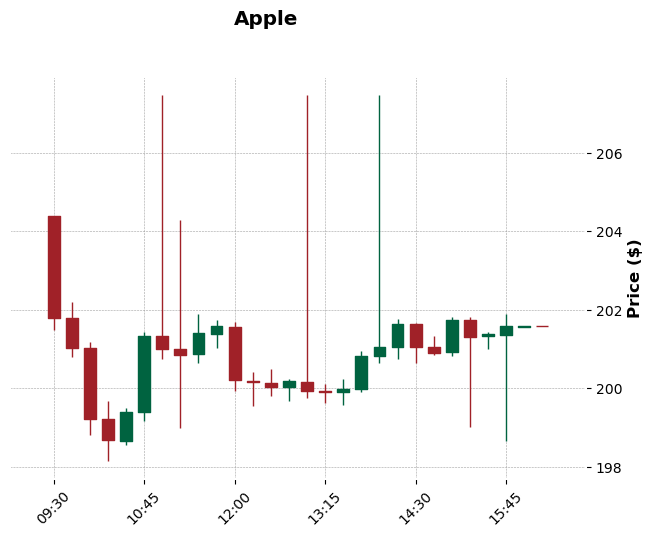

In [60]:
fplt.plot(
            AAPL_15MinBars,
            type='candle',
            style='charles',
            title='Apple',
            ylabel='Price ($)',
            volume=False
        )

In [61]:
AAPL_5MinBars = AAPL_timeindex['Trade Price'].resample('5Min').ohlc()
AAPL_5MinBars.head()

,open,high,low,close
Date_Time,,,,
1900-01-01 09:30:00,204.390,204.3900,201.63,203.1063
1900-01-01 09:35:00,203.080,204.3900,201.70,202.2097
1900-01-01 09:40:00,202.180,202.5718,201.48,201.7950
1900-01-01 09:45:00,201.795,202.2000,201.36,201.5200
1900-01-01 09:50:00,201.520,202.0900,201.33,201.6200


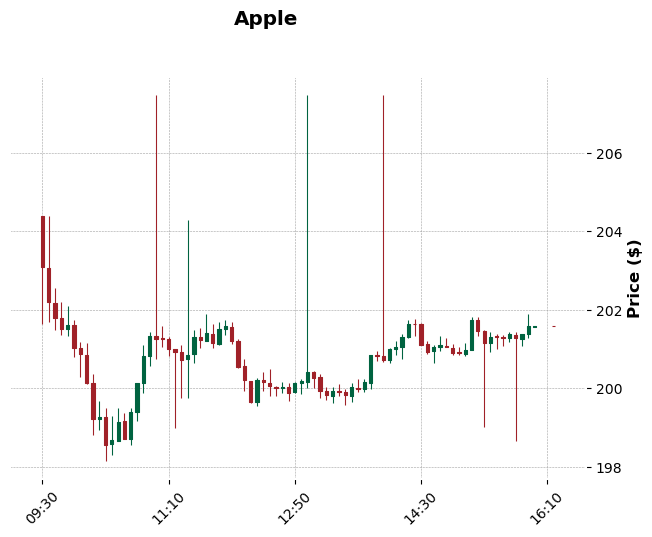

In [62]:
fplt.plot(
            AAPL_5MinBars,
            type='candle',
            style='charles',
            title='Apple',
            ylabel='Price ($)',
            volume=False
        )

In [63]:
AAPL_30SecBars = AAPL_timeindex['Trade Price'].resample('30S').ohlc()
AAPL_30SecBars.head()

,open,high,low,close
Date_Time,,,,
1900-01-01 09:30:00,204.39,204.39,203.02,203.4600
1900-01-01 09:30:30,203.45,204.39,203.13,203.2400
1900-01-01 09:31:00,203.26,204.39,202.28,202.7097
1900-01-01 09:31:30,202.69,204.39,202.30,202.4532
1900-01-01 09:32:00,202.49,204.39,202.11,202.2800


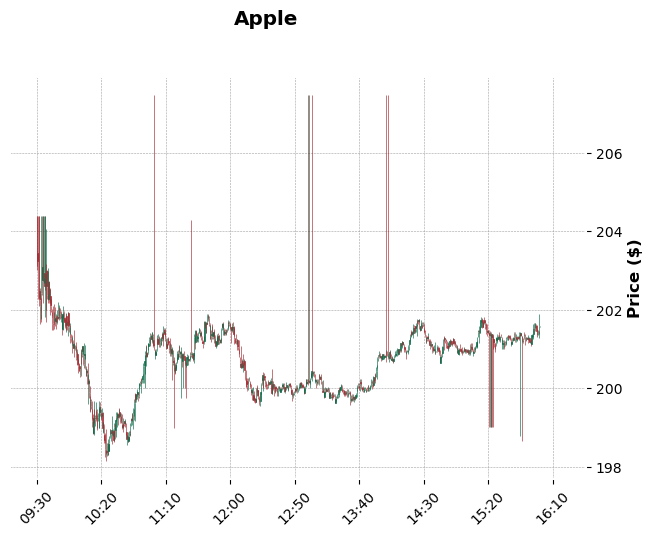

In [64]:
fplt.plot(
            AAPL_30SecBars,
            type='candle',
            style='charles',
            title='Apple',
            ylabel='Price ($)',
            volume=False
        )

Let's take a look at the statistics of these prices. We will look at some histograms and summary statistics. In order to select the number of bins for our histogram we will use the Freedman-Diaconis rule. This is pretty robust and works well in practice. This is 
$$Bin\;Width = 2\frac{IQR(x)}{n^{1/3}}$$
The idea here is we want to check for some kind of distributional characteristics of our data. For a lot of time series models on the market we need to satisfy a number of assumptions, like normality. We shoulds see if there is evidence of this in the data if we intend to use any of those models.

In [65]:
def FD_histogram(df):
    
    q1 = df["close"].quantile(.75)
    q2 = df["close"].quantile(.25)
    n = len(df["close"])
    bin_width = 2*(q1 - q2)*(n**(-1/3))
    num_of_bins = math.floor((df["close"].max()-df["close"].min())/bin_width)
   
    return df["close"].hist(bins=num_of_bins)

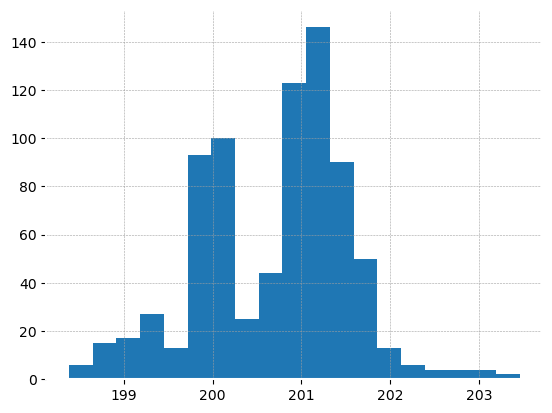

In [66]:
FD_histogram(AAPL_30SecBars)

In [67]:
AAPL_30SecBars.agg({'close':['mean','median','std','skew','kurt']})

,close
mean,200.707060
median,200.900000
std,0.834766
skew,-0.272535
kurt,0.023494


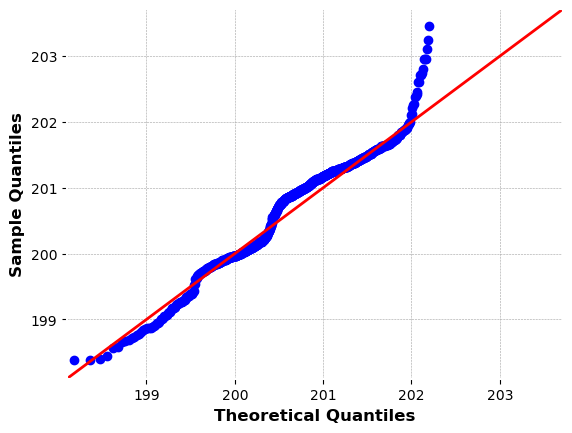

In [68]:
sm.qqplot(np.array(AAPL_30SecBars['close']),
          loc = AAPL_30SecBars['close'].mean(), scale = AAPL_30SecBars['close'].std(), 
          line='45')
pylab.show()

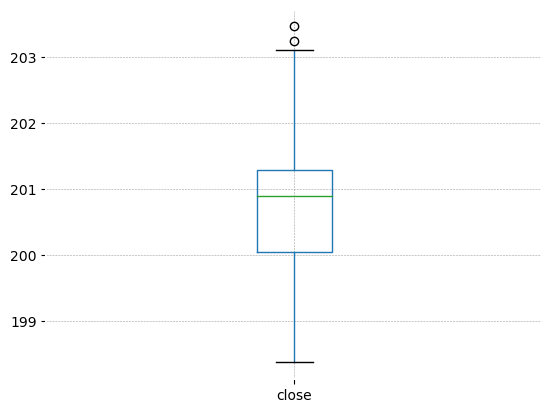

In [69]:
AAPL_30SecBars['close'].plot(kind='box')

We also need to check for autocorrelation in our data. The presence of autocorrelation can be an assumption violation for a number of models. The simplest thing to do is look at an autocorrelation graph over some number of lags. WE can also apply autocorrelation tests like Box-Ljung or if you want something non-parametric the Wald-Wolfowitz test.

Text(0, 0.5, 'Autocorrelation')

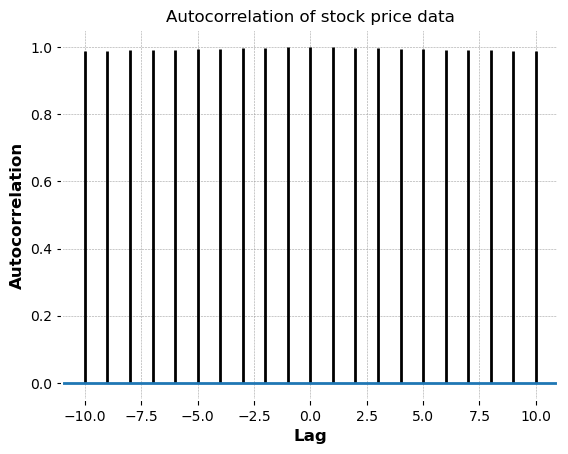

In [70]:
plt.acorr(np.array(AAPL_30SecBars['close'][~np.isnan(AAPL_30SecBars['close'])]),maxlags=10)
plt.title('Autocorrelation of stock price data')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

In [71]:
AAPL_5MinBars.agg({'close':['mean','median','std','skew','kurt']})

,close
mean,200.733878
median,200.933750
std,0.839578
skew,-0.441965
kurt,0.395105


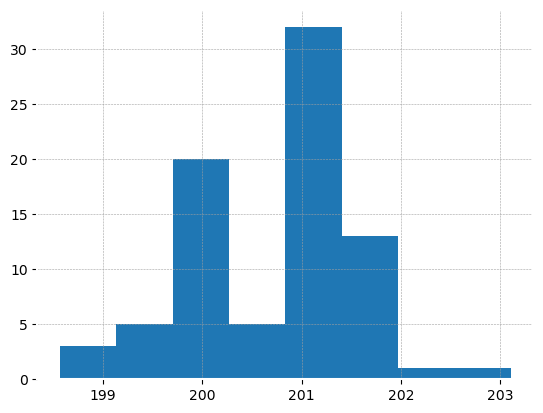

In [72]:
FD_histogram(AAPL_5MinBars)

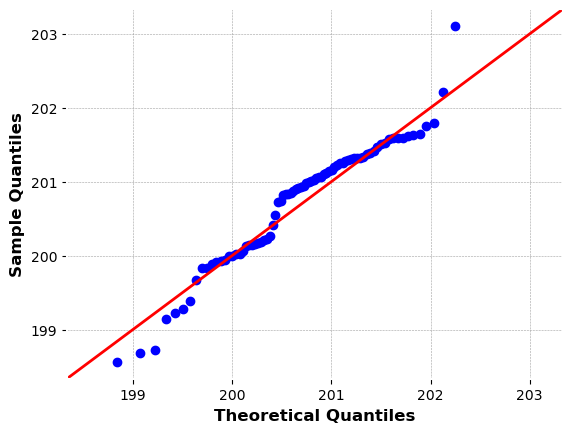

In [73]:
sm.qqplot(np.array(AAPL_5MinBars['close']),
          loc = AAPL_5MinBars['close'].mean(), scale = AAPL_5MinBars['close'].std(), 
          line='45')
pylab.show()

Text(0, 0.5, 'Autocorrelation')

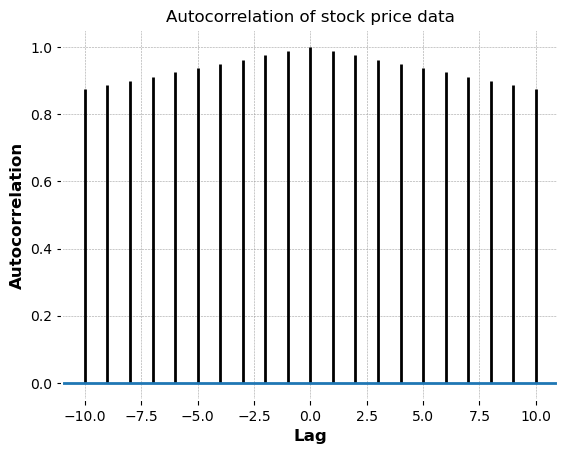

In [74]:
plt.acorr(np.array(AAPL_5MinBars['close'][~np.isnan(AAPL_5MinBars['close'])]),maxlags=10)
plt.title('Autocorrelation of stock price data')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

We will leave a full analysis of 15 minutes bars to you. Here we have just plotted autocorrelation to illustrate the fact that as time grows longer correlation tends to die. Note this is not always true!

Text(0, 0.5, 'Autocorrelation')

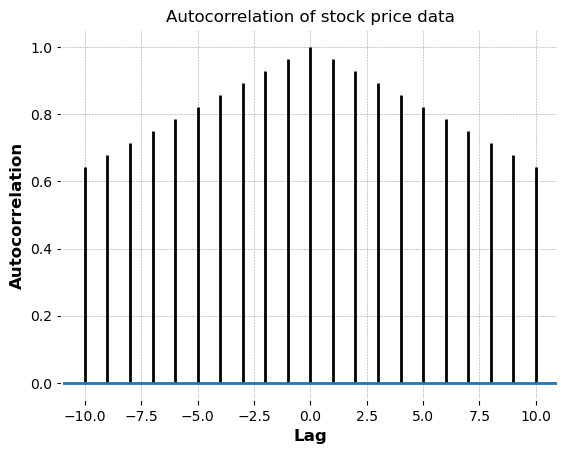

In [75]:
plt.acorr(np.array(AAPL_15MinBars['close'][~np.isnan(AAPL_15MinBars['close'])]),maxlags=10)
plt.title('Autocorrelation of stock price data')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

Notice that the functions in pandas which handle ohlc data do not handle volume. We will have to write our own code to do that.

In [76]:
import BarSampler as bs

In [77]:
AAPL_5Minbars_vol = bs.process_time_bars(AAPL_timeindex,'5Min')
AAPL_5Minbars_vol

,open,high,low,close,Trade Volume
Date_Time,,,,,
1900-01-01 09:35:00,204.390,204.3900,201.63,203.1063,4172982
1900-01-01 09:40:00,203.080,204.3900,201.70,202.2097,1678667
1900-01-01 09:45:00,202.180,202.5718,201.48,201.7950,1965895
1900-01-01 09:50:00,201.795,202.2000,201.36,201.5200,1566717
1900-01-01 09:55:00,201.520,202.0900,201.33,201.6200,1349858
...,...,...,...,...,...
1900-01-01 16:00:00,201.400,201.8900,201.29,201.5900,1513092
1900-01-01 16:05:00,201.570,201.5900,201.57,201.5900,4547
1900-01-01 16:10:00,NaN,NaN,NaN,NaN,0


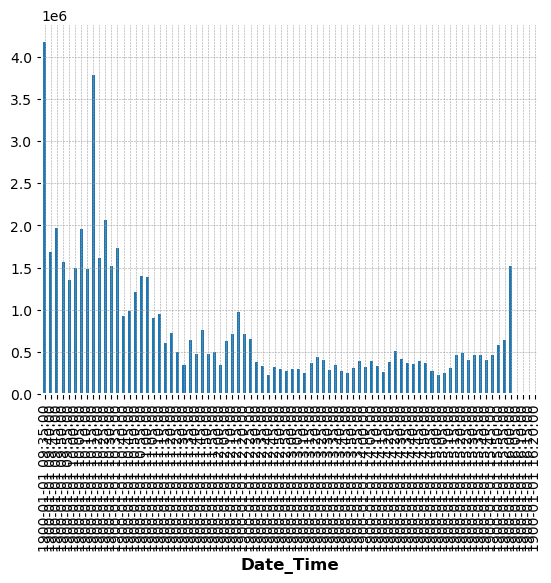

In [78]:
AAPL_5Minbars_vol['Trade Volume'].plot(kind='bar')

### Tick Bars

When people use the term tick they mean a trade. This is a reference to old stock tickers which would utter a ticking sound each time they printed a trade price on a roll of paper tape. For us each line of our dataframe represents one tick. One of the advantages of ticks is that their measurements are in line with the rate at which information arrives in the market. The choice of the number of ticks can depend on many things. The market cap of the stock, the average daily liquidity of the stock, the volatility in the market on a given day, the price of the stock, etc. Developing a methodology for the number of ticks we should sample can be tricky. In fact a lot of time some stock just get excluded from the portfolio selector becuse they do not fit into a frame work developed by the quant.

In [79]:
AAPL_1000TickBars = bs.process_tick_bars(AAPL_timeindex,1000)

In [80]:
AAPL_1000TickBars

,open,high,low,close,volume
Date_Time,,,,,
1900-01-01 09:30:01.431483555,204.3900,204.39,203.92,204.000,136080
1900-01-01 09:30:02.323630103,204.0000,204.39,203.96,203.980,79380
1900-01-01 09:30:03.137551780,203.9600,204.39,203.81,203.810,67095
1900-01-01 09:30:04.617693097,203.8100,204.39,203.59,203.700,90274
1900-01-01 09:30:07.017967095,203.6800,204.39,203.50,203.500,125012
...,...,...,...,...,...
1900-01-01 15:58:24.064348503,201.4900,201.50,201.31,201.350,95985
1900-01-01 15:59:02.496743585,201.3499,201.49,201.34,201.420,113415
1900-01-01 15:59:24.383766579,201.4100,201.46,201.39,201.405,95983


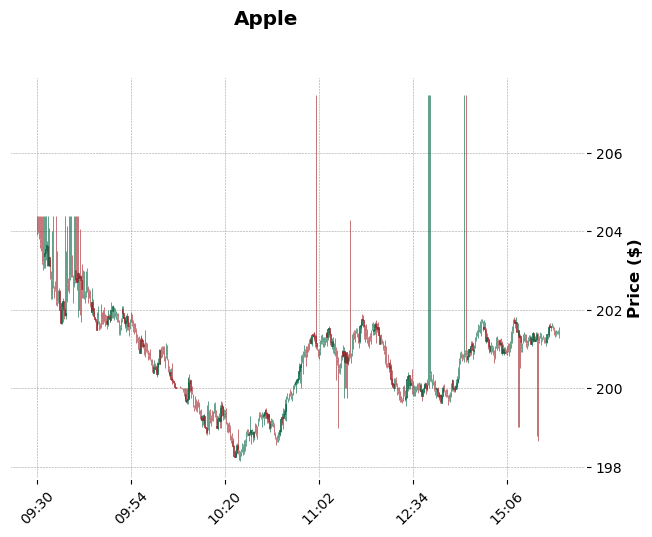

In [81]:
fplt.plot(
            AAPL_1000TickBars,
            type='candle',
            style='charles',
            title='Apple',
            ylabel='Price ($)',
            volume=False
        )

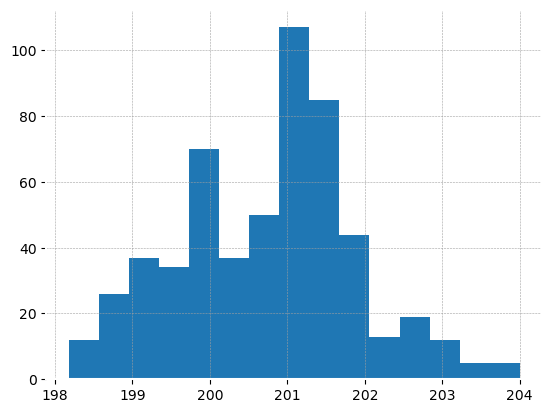

In [82]:
FD_histogram(AAPL_1000TickBars)

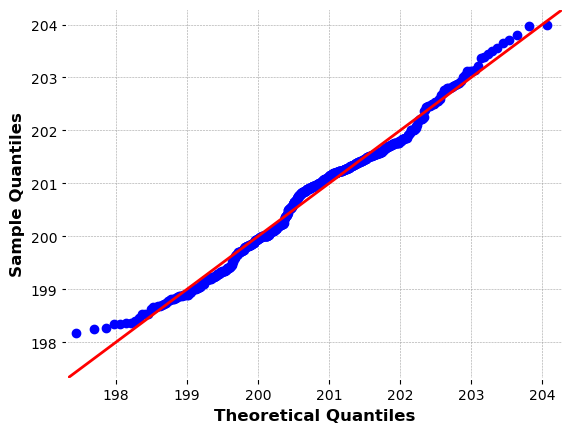

In [83]:
sm.qqplot(np.array(AAPL_1000TickBars['close']),
          loc = AAPL_1000TickBars['close'].mean(), scale = AAPL_1000TickBars['close'].std(), 
          line='45')
pylab.show()

In [84]:
AAPL_1000TickBars.agg({'close':['mean','median','std','skew','kurt']})

,close
mean,200.752702
median,200.937500
std,1.136210
skew,0.052198
kurt,-0.233310


Text(0, 0.5, 'Autocorrelation')

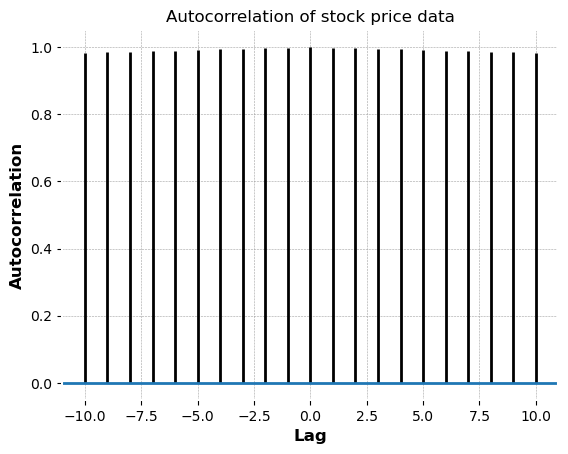

In [85]:
plt.acorr(np.array(AAPL_1000TickBars['close'][~np.isnan(AAPL_1000TickBars['close'])]),maxlags=10)
plt.title('Autocorrelation of stock price data')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

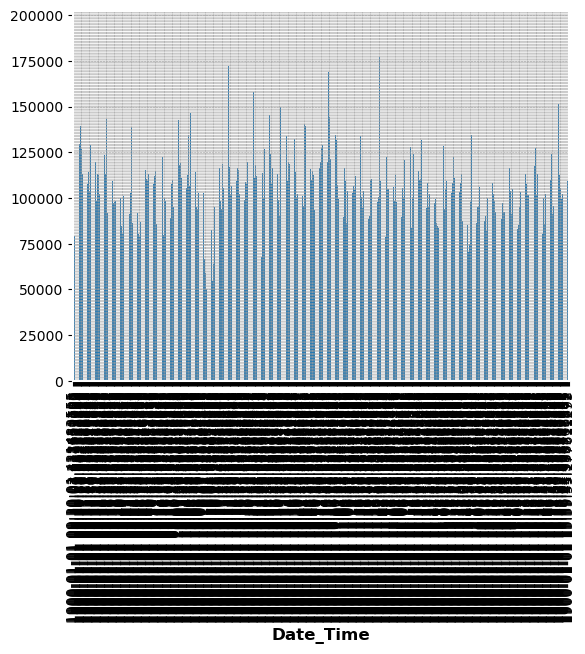

In [86]:
AAPL_1000TickBars['volume'].plot(kind='bar')

### Volume Bars

When you sample you almost always want to sample with a given goal in mind. Consider fill rates. This is how quickly your order gets filled. Sometime, when you place an order for a large number of share, the market maker will break your order up into pieces. This is called order fragmentation. One thing this tells you is that a tick may not represent one trade from one party. It might represent a piece of one trade from one party. Thus if we want to avoid order fragmentation, tick bars do not really give us the information we need. What we can do instead is sample for our data set everytime a predetermined number of shares have been traded, say the number of shares in our large trade. We call this volume bars.  

In [87]:
AAPL_100Kvolbars = bs.process_volume_bars(AAPL_timeindex,100000)

In [88]:
AAPL_100Kvolbars.head()

,open,high,low,close,volume
Date_Time,,,,,
1900-01-01 09:30:01.164475915,204.3900,204.39,203.92,204.1700,100006.0
1900-01-01 09:30:02.137931029,204.1000,204.39,203.99,204.0000,102607.0
1900-01-01 09:30:03.417981672,204.0000,204.39,203.79,204.1700,100418.0
1900-01-01 09:30:05.548371358,203.7900,204.39,203.53,203.8701,100220.0
1900-01-01 09:30:07.196569852,203.9599,204.39,203.48,203.4800,100400.0


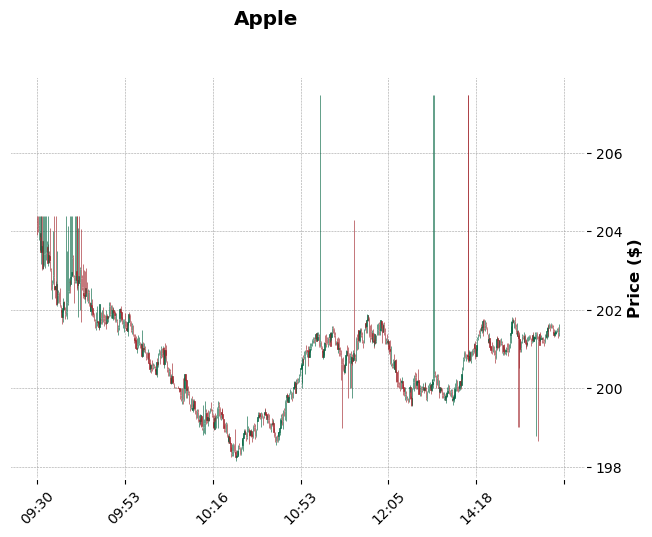

In [89]:
fplt.plot(
            AAPL_100Kvolbars,
            type='candle',
            style='charles',
            title='Apple',
            ylabel='Price ($)',
            volume=False
        )

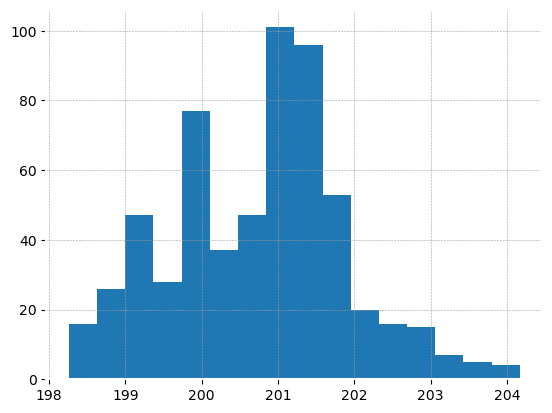

In [90]:
FD_histogram(AAPL_100Kvolbars)

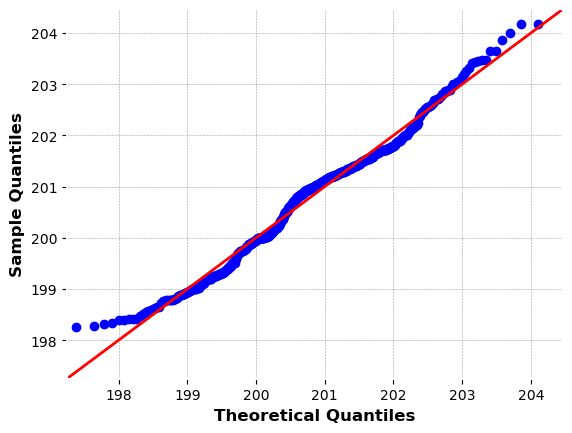

In [91]:
sm.qqplot(np.array(AAPL_100Kvolbars['close']),
          loc = AAPL_100Kvolbars['close'].mean(), scale = AAPL_100Kvolbars['close'].std(), 
          line='45')
pylab.show()

Text(0, 0.5, 'Autocorrelation')

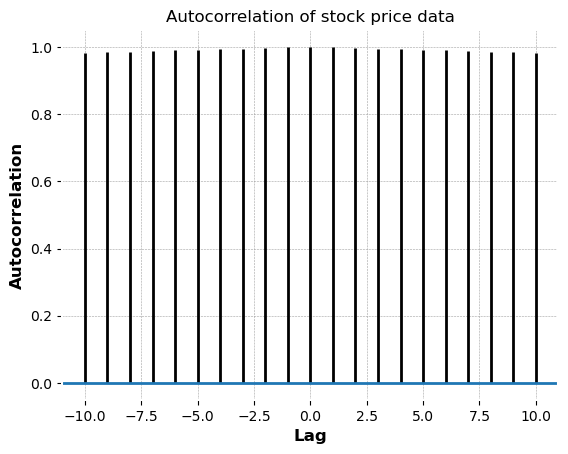

In [92]:
plt.acorr(np.array(AAPL_100Kvolbars['close'][~np.isnan(AAPL_100Kvolbars['close'])]),maxlags=10)
plt.title('Autocorrelation of stock price data')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

In [93]:
AAPL_100Kvolbars.agg({'close':['mean','median','std','skew','kurt']})

,close
mean,200.745767
median,200.940000
std,1.146955
skew,0.087553
kurt,-0.200901


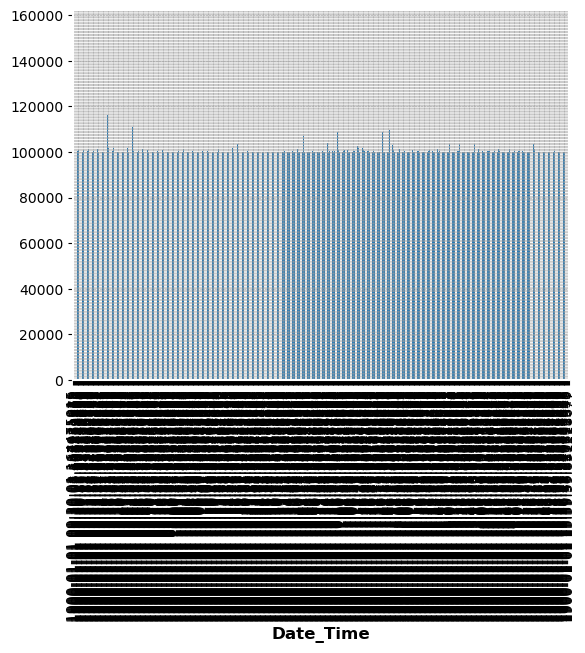

In [94]:
AAPL_100Kvolbars['volume'].plot(kind='bar')

### Dollar Bars

Dollar bar represent sampling from the data everytime a predetermined number of dollars have been traded. So for example if a stock is trading at 30 dollars a share and we see three trade for 100 share, 200 shares, and 150 shares, all at 30 dollars, then 13500 dollars have been traded. Like anything else dollar bars have their uses. Tick bars and volume bars can vary over time due to cooperate actions. While we do adjust our data for things like splits and dividends, we usally don't consider things like share buy backs or the issuance of new share. Dollar bars are much less sensitive to these things. Dollar bars are alow useful for hitting price targets relative to some appreciation or depreciation. So for example you want to exit when the value of your trade has increased by 25%. 

In [101]:
AAPL_200Kdollarbars = bs.process_dollar_bars(AAPL_timeindex,20000000)
AAPL_200Kdollarbars.head()

,open,high,low,close,volume,dollar
Date_Time,,,,,,
1900-01-01 09:30:01.155351817,204.39,204.39,203.92,204.09,98041,2.002384e+07
1900-01-01 09:30:02.136358342,204.10,204.39,203.99,204.00,98057,2.000682e+07
1900-01-01 09:30:03.297633205,204.00,204.39,203.80,203.88,98093,2.000491e+07
1900-01-01 09:30:05.246775144,203.85,204.39,203.59,203.70,98274,2.002360e+07
1900-01-01 09:30:07.017477833,204.17,204.39,203.50,203.50,98876,2.013158e+07


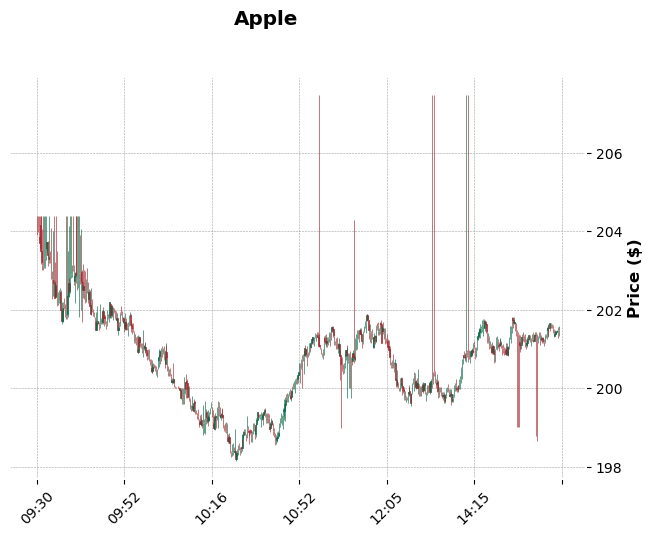

In [102]:
fplt.plot(
            AAPL_200Kdollarbars,
            type='candle',
            style='charles',
            title='Apple',
            ylabel='Price ($)',
            volume=False
        )

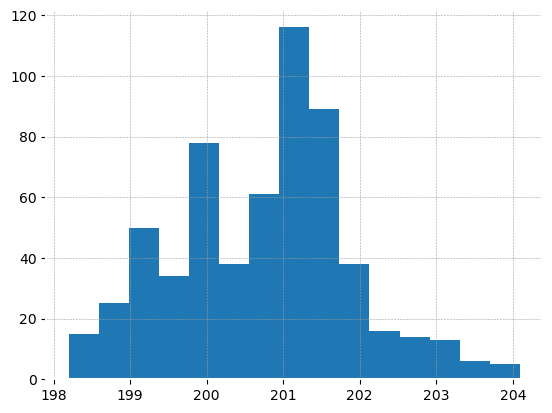

In [103]:
FD_histogram(AAPL_200Kdollarbars)

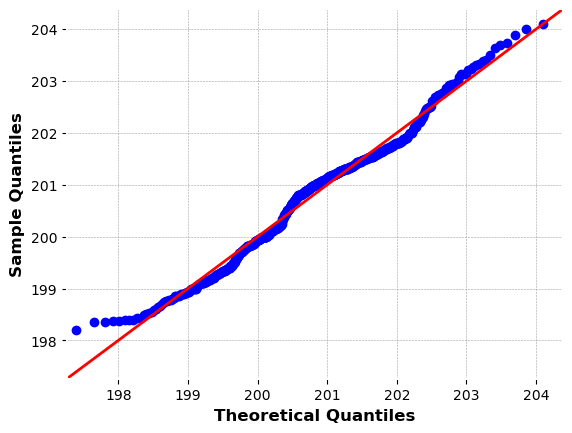

In [104]:
sm.qqplot(np.array(AAPL_200Kdollarbars['close']),
          loc = AAPL_200Kdollarbars['close'].mean(), scale = AAPL_200Kdollarbars['close'].std(), 
          line='45')
pylab.show()

Text(0, 0.5, 'Autocorrelation')

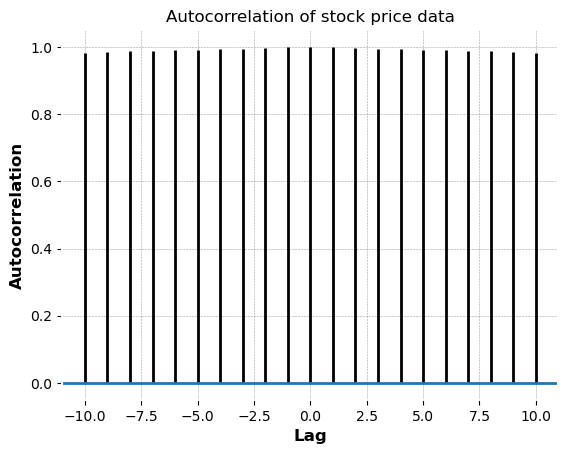

In [105]:
plt.acorr(np.array(AAPL_200Kdollarbars['close'][~np.isnan(AAPL_200Kdollarbars['close'])]),maxlags=10)
plt.title('Autocorrelation of stock price data')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

In [106]:
AAPL_200Kdollarbars.agg({'close':['mean','median','std','skew','kurt']})

,close
mean,200.750359
median,200.934850
std,1.143088
skew,0.064449
kurt,-0.238635
